In [97]:
%matplotlib inline
import sys
import copy
import datetime as dt

import pandas as pd
import numpy as np
import matplotlib
matplotlib.style.use("ggplot")
import matplotlib.pyplot as plt

import pcse
from pcse.models import Wofost72_WLP_FD
print("This notebook was built with:")
print(f"python version: {sys.version}")
print(f"PCSE version: {pcse.__version__}")

from dataproviders import parameters, agromanagement, weather
wofost = Wofost72_WLP_FD(parameters, weather, agromanagement)
wofost.run_till_terminate()
df = pd.DataFrame(wofost.get_output()).set_index("day")

This notebook was built with:
python version: 3.9.19 (main, Apr  6 2024, 17:57:55) 
[GCC 9.4.0]
PCSE version: 5.5.6


In [98]:
override_parameters = {}
override_parameters["TDWI"] = 160
override_parameters["WAV"] = 5
override_parameters["SPAN"] = 33
override_parameters["SMFCF"] = .33

p = copy.deepcopy(parameters)
for par, distr in override_parameters.items():
    p.set_override(par, distr)
member = Wofost72_WLP_FD(p, weather, agromanagement)

In [99]:
from goppy import OnlineGP, SquaredExponentialKernel
model = OnlineGP(SquaredExponentialKernel(.1, 1), noise_var=1)

In [100]:
import warnings
warnings.filterwarnings('ignore')

show_output = True

means = []
mses = []

for date in enumerate(df.index):
    day = date[1].strftime('%Y-%m-%d')

    lais = []
    sms = []
    member.run(1)
    LAI = member.get_variable("LAI")
    SM = member.get_variable("SM")
    lais.append([LAI])
    sms.append([SM])

    if LAI is None or SM is None:
        continue

    if date[1] == df.index[0]:
        model.fit(np.array(sms).T, np.array(lais).T)
        pred = model.predict(np.array(sms).T, what=("mean", "mse"))
    else:
        pred = model.predict(np.array(sms), what=("mean", "mse"))
        model.add(np.array(sms), np.array(lais))
        
    mean = np.squeeze(pred["mean"])  
    means.append(mean)
    mse = pred["mse"]
    mses.append(mse)

means = np.array(means)
mses = np.array(mses).flatten()

In [101]:
results = pd.DataFrame(member.get_output())[:-2] 
results["means"] = means
results["mses"] = mses

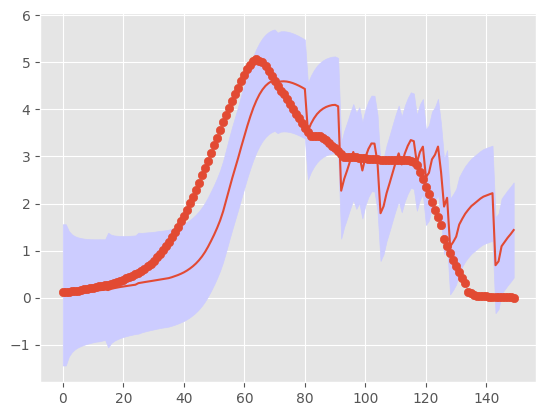

In [102]:
import matplotlib.pyplot as plt
results["means"].plot()
plt.fill_between(results.index, means - mses, means + mses, color=(0.8, 0.8, 1.0))
plt.scatter(results.index, results["LAI"])

In [96]:
results

,day,DVS,LAI,TAGP,TWSO,TWLV,TWST,TWRT,TRA,RD,SM,WWLOW,means,mses
0,2000-01-01,0.000000,0.110240,80.000000,0.0,52.000000,28.000000,80.000000,0.004429,10.0,0.250000,14.090000,0.11762366937874089,[0.0]
1,2000-01-02,0.008867,0.117624,85.358251,0.0,55.482863,29.875388,85.358251,0.002547,11.2,0.244819,14.053816,0.11403703297485358,[0.06005515247246085]
2,2000-01-03,0.017157,0.125290,90.921918,0.0,59.099247,31.822671,90.921918,0.001995,12.4,0.242331,14.038579,0.12601802455801842,[0.002451405241831628]
3,2000-01-04,0.024293,0.133008,96.522179,0.0,62.739416,33.782763,96.522179,0.004869,13.6,0.240616,14.027895,0.1441575506773432,[0.0004508204370652358]
4,2000-01-05,0.032706,0.141716,102.841829,0.0,66.847189,35.994640,102.841829,0.002797,14.8,0.238408,14.005806,0.14425227578842958,[1.0328079707910831e-05]
5,2000-01-06,0.041244,0.151020,109.593526,0.0,71.235792,38.357734,109.593526,0.005986,16.0,0.237164,13.993825,0.17772570259179532,[1.5107463848806901e-06]
6,2000-01-07,0.050482,0.161469,117.176174,0.0,76.164513,41.011661,117.176174,0.009565,17.2,0.235535,13.972238,0.13110286192142886,[4.712797476713604e-07]
7,2000-01-08,0.059432,0.173037,125.571446,0.0,81.621440,43.950006,125.571446,0.005001,18.4,0.233641,13.941868,0.19203287541256614,[3.0735711753493433e-07]
8,2000-01-09,0.068011,0.185226,134.416646,0.0,87.370820,47.045826,134.416646,0.002892,19.6,0.232850,13.928579,0.19529193459787375,[6.240181783301324e-06]
9,2000-01-10,0.075558,0.197045,142.993448,0.0,92.945741,50.047707,142.993448,0.009050,20.8,0.232435,13.921199,0.260344592420299,[0.00037327630255745703]
